In [3]:
'''
Adapated from: https://github.com/CVxTz/kinship_prediction/blob/master/code/vgg_face.py
to parse the images and data
This is NOT used to make the model!
Additionally, this is run on a Windows OS. Some code may not be need if it is on a UNIX or LINUX OS.
'''
import pandas as pd
from glob import glob #for finding files recursively
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from PIL import Image

In [2]:
!unzip '/content/train.zip' -d '/content/train'

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/F0099/MID1/P11523_face3.jpg  
  inflating: /content/train/F0099/MID1/P11536_face2.jpg  
  inflating: /content/train/F0099/MID1/P01025_face1.jpg  
  inflating: /content/train/F0099/MID1/P11539_face1.jpg  
  inflating: /content/train/F0099/MID1/P01021_face1.jpg  
  inflating: /content/train/F0099/MID1/P01026_face1.jpg  
  inflating: /content/train/F0099/MID1/P11519_face3.jpg  
  inflating: /content/train/F0099/MID1/P11535_face2.jpg  
  inflating: /content/train/F0099/MID1/P01027_face1.jpg  
  inflating: /content/train/F0099/MID1/P11518_face2.jpg  
  inflating: /content/train/F0099/MID1/P11520_face3.jpg  
  inflating: /content/train/F0099/MID6/P11523_face2.jpg  
  inflating: /content/train/F0099/MID6/P11518_face4.jpg  
  inflating: /content/train/F0099/MID6/P11522_face4.jpg  
  inflating: /content/train/F0099/MID6/P11519_face2.jpg  
  inflating: /content/train/F0099/MID6/P11539_face2.jpg  
  inflating: /content

In [4]:
relationshipsCSV = "./train_relationships.csv"
train_images_folder = "./train/"
#what is the difference between train and train-face?


In [5]:
available_images = glob(train_images_folder + "*/*/*.jpg")
'''
Only for windows pc:
'''
for a in range(0, len(available_images)):
    available_images[a] = available_images[a].replace("\\", "/")

all_ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in available_images] #all the people
all_ppl

['F0840/MID3',
 'F0840/MID3',
 'F0840/MID1',
 'F0840/MID1',
 'F0840/MID1',
 'F0840/MID1',
 'F0840/MID1',
 'F0840/MID1',
 'F0840/MID1',
 'F0840/MID1',
 'F0840/MID1',
 'F0494/MID3',
 'F0494/MID3',
 'F0494/MID3',
 'F0494/MID3',
 'F0494/MID3',
 'F0494/MID3',
 'F0494/MID1',
 'F0494/MID1',
 'F0494/MID1',
 'F0494/MID1',
 'F0494/MID1',
 'F0494/MID1',
 'F0494/MID1',
 'F0494/MID2',
 'F0494/MID2',
 'F0494/MID2',
 'F0494/MID2',
 'F0494/MID2',
 'F0494/MID2',
 'F0494/MID2',
 'F0494/MID5',
 'F0494/MID5',
 'F0494/MID5',
 'F0494/MID5',
 'F0494/MID5',
 'F0494/MID4',
 'F0494/MID4',
 'F0494/MID4',
 'F0494/MID4',
 'F0494/MID4',
 'F0494/MID4',
 'F0494/MID4',
 'F0299/MID3',
 'F0299/MID3',
 'F0299/MID3',
 'F0299/MID3',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID1',
 'F0299/MID2',
 'F0299/MI

In [50]:
#creating the training set
personPathFile = defaultdict(list)
for x in available_images:
    personPathFile[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

#read from the csv to create a list of tuples
relationships = pd.read_csv(relationshipsCSV)
relationship_pairs = [(row['p1'], row['p2']) for index, row in relationships.iterrows()] # Create a list of tuples
relationship_pairs = [x for x in relationship_pairs if x[0] in all_ppl and x[1] in all_ppl] #data cleaning

#converting into dictionary of person is related to this list of people
relationshipDict = defaultdict(list)
for item in relationship_pairs:
  relationshipDict[item[0]].append(item[1]) #you do not need to consider the item[1] because the CSV is already pretty clean


#create more data by finding the 'negative pair'
notRelationshipDict = defaultdict(list)
set_all_ppl = set(all_ppl)
#for each key(person) in the relationship dictionary, find the non-relations
for k,v in relationshipDict.items():
    notRelationshipDict[k]=list(set_all_ppl-set(v))



# convert both dictionaries into a list of tuples with 1, 0 as labels
# for each of the image, take the first image path stored in the dictionary made earlier
# then take each of the path file in the item

trainData = []
for k,v in relationshipDict.items():
    for relation in v:
        for item in personPathFile[k]:
          for item2 in personPathFile[relation]:
                trainData.append((item, item2,1))


positiveRelationsCount = len(trainData)
print("Current Length of positive relationships: ", len(trainData))
for k,v in notRelationshipDict.items():
    for Notrelation in v:
        for item in personPathFile[k]:
          for item2 in personPathFile[Notrelation]:
                trainData.append((item, item2,0))
    if len(trainData)>=positiveRelationsCount*2:
      break


'''

# Storing the list of tuples in a text file
with open('Cleaned_Data.txt', 'w') as file:
    for item in trainData:
        file.write(f"{item[0]}, {item[1]}, {item[2]}\n")


trainData1 = []
with open('Cleaned_Data.txt', 'r') as file:
    for l in file:
        eachTuple = l.strip().split(', ')
        trainData1.append(((eachTuple[0]), eachTuple[1], int(eachTuple[2])))


'''

Current Length of positive relationships:  165179


'\n\n# Storing the list of tuples in a text file\nwith open(\'Cleaned_Data.txt\', \'w\') as file:\n    for item in trainData:\n        file.write(f"{item[0]}, {item[1]}, {item[2]}\n")\n\n\ntrainData1 = []\nwith open(\'Cleaned_Data.txt\', \'r\') as file:\n    for l in file:\n        eachTuple = l.strip().split(\', \')\n        trainData1.append(((eachTuple[0]), eachTuple[1], int(eachTuple[2])))\n\n\n'

In [51]:
#Checking whether the trainData is created correctly
print("Total Length of all relationships: ", len(trainData))
print(trainData[:100]) #print the first 100

Total Length of all relationships:  400228
[('./train/F0002/MID1/P00017_face3.jpg', './train/F0002/MID3/P00017_face1.jpg', 1), ('./train/F0002/MID1/P00017_face3.jpg', './train/F0002/MID3/P00018_face2.jpg', 1), ('./train/F0002/MID1/P00017_face3.jpg', './train/F0002/MID3/P00013_face3.jpg', 1), ('./train/F0002/MID1/P00017_face3.jpg', './train/F0002/MID3/P00010_face1.jpg', 1), ('./train/F0002/MID1/P00017_face3.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID1/P00017_face3.jpg', './train/F0002/MID3/P00009_face1.jpg', 1), ('./train/F0002/MID1/P00017_face3.jpg', './train/F0002/MID3/P00011_face3.jpg', 1), ('./train/F0002/MID1/P00017_face3.jpg', './train/F0002/MID3/P00014_face1.jpg', 1), ('./train/F0002/MID1/P00012_face2.jpg', './train/F0002/MID3/P00017_face1.jpg', 1), ('./train/F0002/MID1/P00012_face2.jpg', './train/F0002/MID3/P00018_face2.jpg', 1), ('./train/F0002/MID1/P00012_face2.jpg', './train/F0002/MID3/P00013_face3.jpg', 1), ('./train/F0002/MID1/P00012_face2.jpg', './

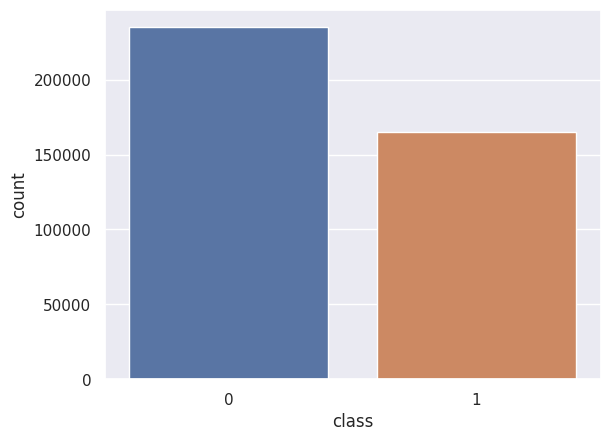

In [52]:
#checking the balance of positive and negative data
dfTrainData = pd.DataFrame (trainData, columns=['img1', 'img2', 'class'])
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=dfTrainData)

In [53]:
'''
Adapted from: https://github.com/ale-mauro/Kinship-Recognition/blob/main/KinshipRecognition_Naive_DenseNet161_ResNet.ipynb
Obtaining the training and validation set to use the following model:
https://keras.io/examples/vision/siamese_network/

The idea is to split to obtain a "triple" set:
1. an anchor
2. positive
3. negative
'''

'\nAdapted from: https://github.com/ale-mauro/Kinship-Recognition/blob/main/KinshipRecognition_Naive_DenseNet161_ResNet.ipynb\nObtaining the training and validation set to use the following model:\nhttps://keras.io/examples/vision/siamese_network/\n\nThe idea is to split to obtain a "triple" set:\n1. an anchor\n2. positive\n3. negative\n'

In [54]:
#use the pytorch built in Dataset function
class trainingDataset(Dataset):
    def __init__(self, _data, _transform=None):
        self.data = _data #choose either train or val dataset to use
        self.transform = _transform


    def __getitem__(self,index):

        first_img_path = self.data[index][0]
        second_img_path = self.data[index][1]
        img1Opened = Image.open(first_img_path)
        img2Opened = Image.open(second_img_path)


        #it is important to transform the images into tensor format
        if self.transform is not None:
            img1Opened = self.transform(img1Opened)
            img2Opened = self.transform(img2Opened)
        return img1Opened, img2Opened , self.data[index][2]

    def __len__(self):
        return len(self.data)#essential for choose the num of data in one epoch


In [55]:
from sklearn.model_selection import train_test_split
BATCH_SIZE=64
IMG_SIZE=224
NUM_WORKERS = 8


trainSet, valSet = train_test_split(trainData, test_size=0.5, random_state=42)
#TODO: Normalize the data

#Training set and training loader
trainset = trainingDataset(_data=trainSet,
                                        _transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))

valset = trainingDataset(_data=valSet,
                                        _transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))



trainloader = DataLoader(trainset,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        batch_size=BATCH_SIZE)


valloader = DataLoader(valset,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        batch_size=BATCH_SIZE)






/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


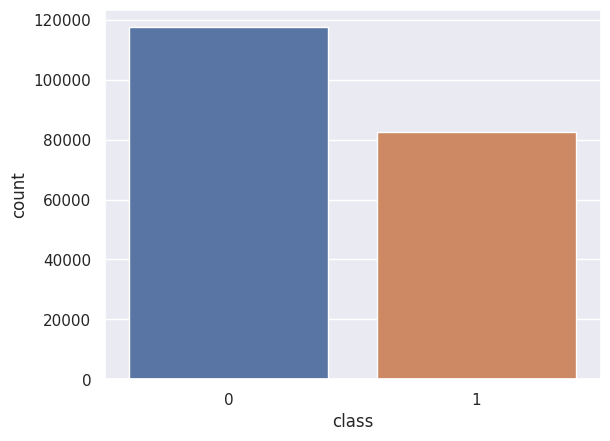

In [56]:
dfTrainData = pd.DataFrame (trainSet, columns=['img1', 'img2', 'class'])
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=dfTrainData)




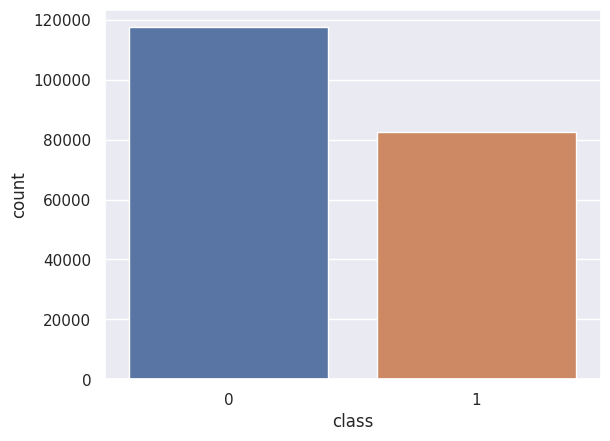

In [57]:
dfTrainData = pd.DataFrame (valSet, columns=['img1', 'img2', 'class'])
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=dfTrainData)

In [58]:
import torchvision.models as models

class SiameseVGG(nn.Module):
    def __init__(self):
        super(SiameseVGG, self).__init__()

        model = models.vgg19(weights=VGG19_Weights.DEFAULT) #Carico VGGFace19 già allenata
        #Freezing tutti i layers
        for param in model.parameters():
          param.require_grad = False

        #Estrazione blocco convoluzionale
        self.cnn1 = torch.nn.Sequential(*(list(model.children())[:-1]))

        #Aggiungo nuovi layers pienamente connessi
        model.classifier = nn.Sequential(
            nn.Linear(50176, 460),
            nn.ReLU(),
            nn.Linear(460, 230),
            nn.ReLU(),
            nn.Linear(230, 2)
        )

        self.fc = model.classifier

    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)

        output = torch.cat((output1, output2),1)
        #print(output.shape) #è l'output che deve aver il primo fc
        output = self.fc(output)
        return output

# Create an instance of the SiameseVGG network.
model = SiameseVGG()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 112MB/s]


In [59]:
#Here you can chose the network you want by changing the Siamese Network
net = SiameseVGG().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss #TODO: change to BCELoss or BSEwithLogitLoss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


RuntimeError: ignored

In [ ]:
print(valSet)

In [ ]:
import numpy as np

counter = []
iteration_number= 0

BATCH_SIZE=64
NUMBER_EPOCHS=21
epoch_accuracies = np.array([])

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch)
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels = data
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
        optimizer.zero_grad()
        outputs = net(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    accuracy = 100 * correct_val / total_val
    epoch_accuracies = np.append(epoch_accuracies, accuracy)
    print(f"Epoch [{epoch+1}/{NUMBER_EPOCHS}] Accuracy: {accuracy}")

best_accuracy = np.amax(epoch_accuracies)
best_epoch = epoch_accuracies.argmax()
print('END TRAINING: BEST EPOCH: ', best_epoch, ' WITH ACCURACY: ', best_accuracy)


In [22]:
  !unzip '/content/test.zip' -d '/content/test'

Streaming output truncated to the last 5000 lines.
  inflating: /content/test/face04688.jpg  
  inflating: /content/test/face03972.jpg  
  inflating: /content/test/face02593.jpg  
  inflating: /content/test/face00836.jpg  
  inflating: /content/test/face05284.jpg  
  inflating: /content/test/face03261.jpg  
  inflating: /content/test/face00582.jpg  
  inflating: /content/test/face02696.jpg  
  inflating: /content/test/face05325.jpg  
  inflating: /content/test/face04973.jpg  
  inflating: /content/test/face02902.jpg  
  inflating: /content/test/face06245.jpg  
  inflating: /content/test/face00645.jpg  
  inflating: /content/test/face03284.jpg  
  inflating: /content/test/face00188.jpg  
  inflating: /content/test/face05490.jpg  
  inflating: /content/test/face01683.jpg  
  inflating: /content/test/face05566.jpg  
  inflating: /content/test/face03288.jpg  
  inflating: /content/test/face00045.jpg  
  inflating: /content/test/face06050.jpg  
  inflating: /content/test/face02871.jpg  
  i

In [23]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv

    def __init__(self,transform=None):
        self.test_df = pd.read_csv('/content/sample_submission.csv')
        self.transform = transform

    def __getitem__(self,index):

        img0_path = self.test_df.iloc[index].img_pair.split("-")[0]
        img1_path = self.test_df.iloc[index].img_pair.split("-")[1]

        img0 = Image.open('test/'+img0_path)
        img1 = Image.open('test/'+img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1

    def __len__(self):
        return len(self.test_df)

In [24]:
testset = testDataset(transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be

In [26]:

#Testing impiega circa 1 minuto (per Naive) e circa 5 minuti (per reti preaddestrate)
test_df = pd.read_csv('/content/sample_submission.csv')
predictions=[]
with torch.no_grad():
    for data in testloader:
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        outputs = net(img0,img1)
        _, predicted = torch.max(outputs, 1)
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)

test_df['is_related'] = predictions
test_df.to_csv("test_Results.csv", index=False) #submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed

,img_pair,is_related
0,face05508.jpg-face01210.jpg,1.0
1,face05750.jpg-face00898.jpg,1.0
2,face05820.jpg-face03938.jpg,1.0
3,face02104.jpg-face01172.jpg,1.0
4,face02428.jpg-face05611.jpg,1.0
5,face01219.jpg-face00274.jpg,1.0
6,face04262.jpg-face00555.jpg,1.0
7,face03697.jpg-face01892.jpg,1.0
8,face03524.jpg-face00319.jpg,1.0
9,face03410.jpg-face05368.jpg,1.0


In [ ]:
# # Salvataggio modello
# saved_path = "/content/drive/MyDrive/ComputerVisionProject/pretrained_model/NaiveNet(test).pth"
# torch.save(net, saved_path)